# Simple Chess Algorithm

Let's familiarize with the chess engine...

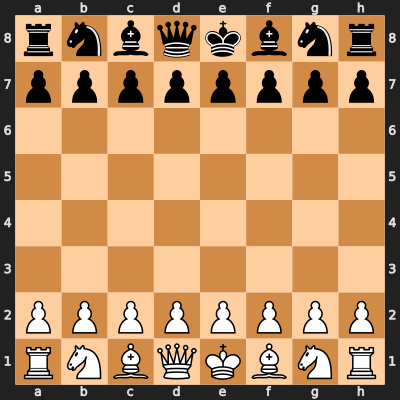

In [1]:
import chess
import chess.svg

board = chess.Board()

chess.svg.board(board, size=400)

What are the pieces worth? The algorithm needs a value for each piece in order to compute a score for each move.

In [2]:
def get_piece_value(piece: chess.Piece) -> int:
    if not piece:
        return 0
    symbol = piece.symbol().lower()
    if symbol == "p":
        return 1
    elif symbol == "n":
        return 3
    elif symbol == "b":
        return 3
    elif symbol == "r":
        return 5
    elif symbol == "q":
        return 9
    elif symbol == "k":
        # use some VERY high value for the king
        return 1337

# Minimax Pseudocode

```txt
function minimax(node, depth, maximizingPlayer):
    if depth = 0 or node is a terminal node:
        return evaluate(node)
    
    if maximizingPlayer:
        maxEval = -infinity
        for each child of node:
            eval = minimax(child, depth - 1, FALSE)
            maxEval = max(maxEval, eval)
        return maxEval
    else:
        minEval = +infinity
        for each child of node:
            eval = minimax(child, depth - 1, TRUE)
            minEval = min(minEval, eval)
        return minEval

```

In [3]:
import chess

INF = 2**31-1
DEPTH = 3

def evaluate(board: chess.Board) -> int:
    return sum(get_piece_value(board.piece_at(i)) for i in range(63))


def minimax(board: chess.Board, depth:int, maximize:bool):
    if depth == 0 or board.is_game_over():
        return evaluate(board)
    pass

    if maximize:
        best_score = -INF
        for move in board.legal_moves:
            board.push(move)
            score = minimax(board, depth -1, False)
            board.pop()
            best_score = max(score)
        return best_score
    else:
        lowest_score = INF
        for move in board.legal_moves:
            board.push(move)
            score = minimax(board, depth -1, False)
            board.pop()
            lowest_score = min(lowest_score, score)
        return lowest_score


def get_next_move(board: chess.Board) -> chess.Move:
    best_move = None
    best_score = -INF

    for move in board.legal_moves:
        board.push(move)
        score = minimax(board, depth=DEPTH, maximize=False)
        board.pop()
        if score > best_score:
            best_score = score
            best_move = move
    return best_move


So... What is the best move according to the `minimax` function?

In [4]:
move = get_next_move(board)

In [5]:
from IPython import display

def draw_board_with_move(move):
    arrow = chess.svg.Arrow(move.from_square, move.to_square, color="#0000cccc")
    svg = chess.svg.board(board, size=400, arrows=[arrow,])
    display.display(svg)

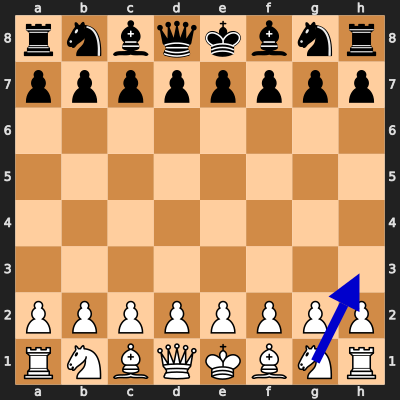

In [6]:
draw_board_with_move(move)


"A knight on the rim is grim."

In [7]:
board.push(move)

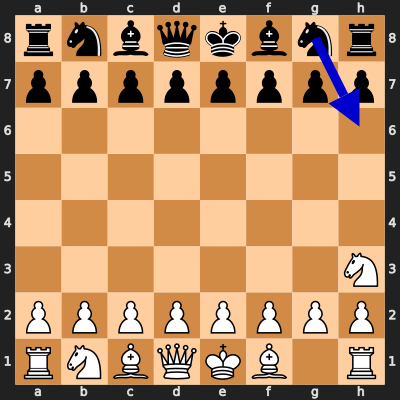

In [8]:
move = get_next_move(board)
draw_board_with_move(move)
board.push(move)

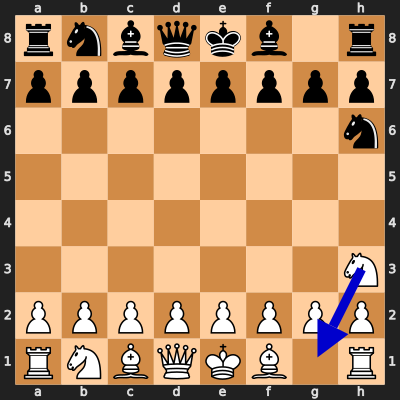

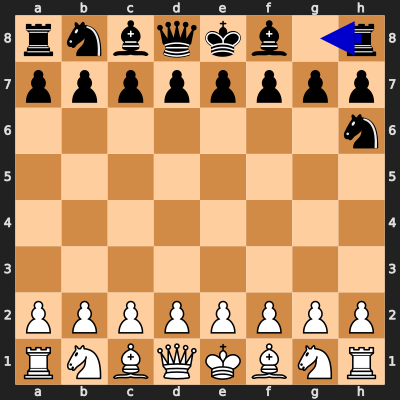

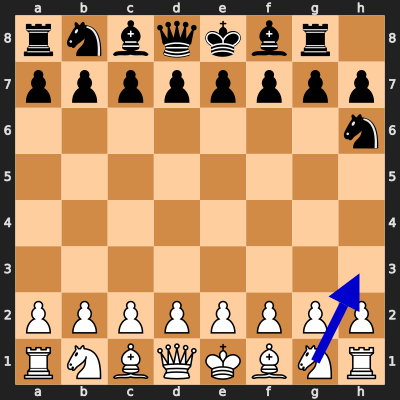

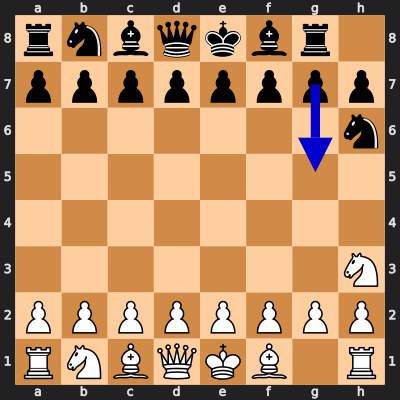

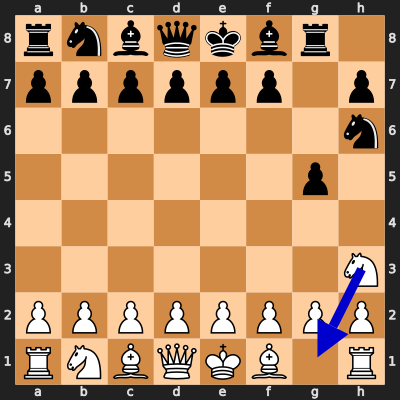

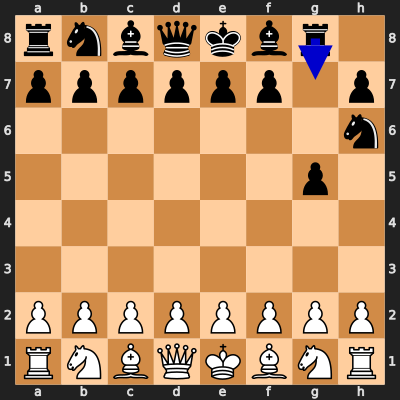

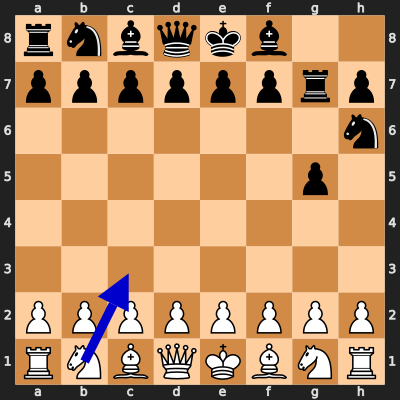

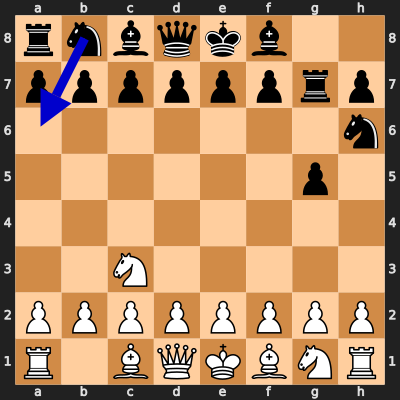

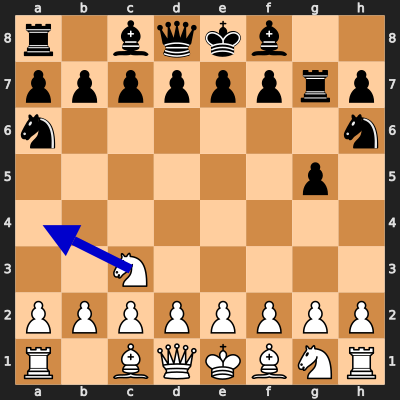

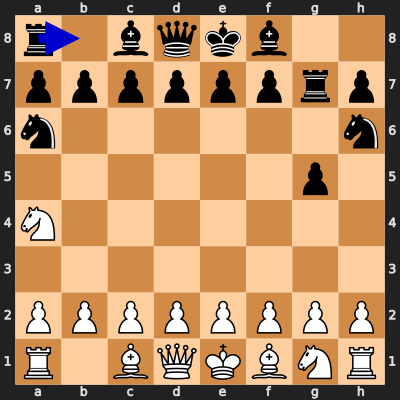

In [9]:
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

# Problems

- the search function `minimax` is not aware about the color
- the eval function `evaluate` only sums the material without considering the relative position of each piece

## Color Awareness

In order to make the minimax function aware of the color, a sign can be introduced (`-1`, `1`). The algorithm then becomes `negamax`.


In [10]:
def negamax(board: chess.Board, depth:int):
    if depth == 0 or board.is_game_over():
        return evaluate(board)

    max_score = -INF
    for move in board.legal_moves:
        board.push(move)
        # invert the sign/score, because the next move is made by the opponent
        score = -negamax(board, depth - 1)
        board.pop()
        max_score = max(max_score, score)

    return max_score


# Positional Awareness

The following features are indicators that a player is more likely to win:

- having more material is good
- having more mobility is good
- king safety is good
- center control is good

For each property a distinct evaluation function can be defined:

- **material** can be expressed as the sum of all pieces based on their value
- **mobility** can be expressed as the number of possible moves
- **king safety** can be expressed as the number of attacking pieces
- **center control** can be expressed by assigining higher numbers to center pieces


# Material

```txt
materialScore = kingWt  * (wK-bK)
              + queenWt * (wQ-bQ)
              + rookWt  * (wR-bR)
              + knightWt* (wN-bN)
              + bishopWt* (wB-bB)
              + pawnWt  * (wP-bP)
```

The weights can differ based on the position of each piece. A central knight is worth more than a knight at the border of the game. Thankfully, there are positional tables for each piece available at [chessprogramming.org](https://www.chessprogramming.org/Simplified_Evaluation_Function). These tables give bonuses for pieces standing well and penalties for pieces standing badly.


In [11]:
import functools

PAWN_WEIGHT = 100
KNIGHT_WEIGHT = 300
BISHOP_WEIGHT = 350  # in my opionion, a bishop is worth more than a knight
ROOK_WEIGHT = 500
QUEEN_WEIGHT = 900
KING_WEIGHT = 10_000


def eval_material(board: chess.Board):
    pieces = board.pieces
    white_pieces = functools.partial(pieces, color=chess.WHITE)
    black_pieces = functools.partial(pieces, color=chess.BLACK)

    raw_material = (KING_WEIGHT * (len(white_pieces(chess.KING)) - len(black_pieces(chess.KING)))
                    + QUEEN_WEIGHT * (len(white_pieces(chess.QUEEN)) - len(black_pieces(chess.QUEEN)))
                    + ROOK_WEIGHT * (len(white_pieces(chess.ROOK)) - len(black_pieces(chess.ROOK)))
                    + BISHOP_WEIGHT * (len(white_pieces(chess.BISHOP)) - len(black_pieces(chess.BISHOP)))
                    + KNIGHT_WEIGHT * (len(white_pieces(chess.KNIGHT)) - len(black_pieces(chess.KNIGHT)))
                    + PAWN_WEIGHT * (len(white_pieces(chess.PAWN)) - len(black_pieces(chess.PAWN))))
    return raw_material

This looks better. But the computer still places the pieces at the side of the board...

In [12]:
PAWN_POS_TABLE = [
 0,  0,  0,  0,  0,  0,  0,  0,
 5, 10, 10,-20,-20, 10, 10,  5,
 5, -5,-10,  0,  0,-10, -5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5,  5, 10, 25, 25, 10,  5,  5,
10, 10, 20, 30, 30, 20, 10, 10,
50, 50, 50, 50, 50, 50, 50, 50,
 0,  0,  0,  0,  0,  0,  0,  0]

KNIGHT_POS_TABLE = [
-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  5,  5,  0,-20,-40,
-30,  5, 10, 15, 15, 10,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 10, 15, 15, 10,  0,-30,
-40,-20,  0,  0,  0,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]

BISHOP_POS_TABLE = [
-20,-10,-10,-10,-10,-10,-10,-20,
-10,  5,  0,  0,  0,  0,  5,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10,-10,-10,-10,-10,-20]

ROOK_POS_TABLE = [
  0,  0,  0,  5,  5,  0,  0,  0,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  5, 10, 10, 10, 10, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]

QUEEN_POS_TABLE = [
-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  5,  5,  5,  5,  5,  0,-10,
  0,  0,  5,  5,  5,  5,  0, -5,
 -5,  0,  5,  5,  5,  5,  0, -5,
-10,  0,  5,  5,  5,  5,  0,-10,
-10,  0,  0,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]

KING_POS_TABLE = [
 20, 30, 10,  0,  0, 10, 30, 20,
 20, 20,  0,  0,  0,  0, 20, 20,
-10,-20,-20,-20,-20,-20,-20,-10,
-20,-30,-30,-40,-40,-30,-30,-20,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30]


def eval_material(board: chess.Board):
    pieces = board.pieces
    white_pieces = functools.partial(pieces, color=chess.WHITE)
    black_pieces = functools.partial(pieces, color=chess.BLACK)


    # Raw Material
    raw_material = (KING_WEIGHT * (len(white_pieces(chess.KING)) - len(black_pieces(chess.KING)))
                    + QUEEN_WEIGHT * (len(white_pieces(chess.QUEEN)) - len(black_pieces(chess.QUEEN)))
                    + ROOK_WEIGHT * (len(white_pieces(chess.ROOK)) - len(black_pieces(chess.ROOK)))
                    + BISHOP_WEIGHT * (len(white_pieces(chess.BISHOP)) - len(black_pieces(chess.BISHOP)))
                    + KNIGHT_WEIGHT * (len(white_pieces(chess.KNIGHT)) - len(black_pieces(chess.KNIGHT)))
                    + PAWN_WEIGHT * (len(white_pieces(chess.PAWN)) - len(black_pieces(chess.PAWN))))

    # Piece-Square Values
    pawn_sq = sum(PAWN_POS_TABLE[i] for i in white_pieces(chess.PAWN)) - sum(PAWN_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.PAWN))
    knight_sq = sum(KNIGHT_POS_TABLE[i] for i in white_pieces(chess.KNIGHT)) - sum(KNIGHT_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.KNIGHT))
    bishop_sq = sum(BISHOP_POS_TABLE[i] for i in white_pieces(chess.BISHOP)) - sum(BISHOP_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.BISHOP))
    rook_sq = sum(ROOK_POS_TABLE[i] for i in white_pieces(chess.ROOK)) - sum(ROOK_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.ROOK))
    queen_sq = sum(QUEEN_POS_TABLE[i] for i in white_pieces(chess.QUEEN)) - sum(QUEEN_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.QUEEN))
    king_sq = sum(KING_POS_TABLE[i] for i in white_pieces(chess.KING)) - sum(KING_POS_TABLE[chess.square_mirror(i)] for i in black_pieces(chess.KING))

    total = raw_material + pawn_sq + bishop_sq + rook_sq + queen_sq + king_sq
    return total


In [13]:
def evaluate(board: chess.Board) -> int:
    if board.is_checkmate():
        if board.turn:
            return -INF
        else:
            return INF
    if board.is_stalemate():
        return 0
    if board.is_insufficient_material():
        return 0
        
    material_score = eval_material(board)
    return material_score if board.turn else material_score * -1
    

In [14]:
def get_next_move(board: chess.Board) -> chess.Move:
    best_move = None
    best_score = -INF

    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, DEPTH - 1)
        board.pop()
        if score > best_score:
            best_score = score
            best_move = move
    return best_move

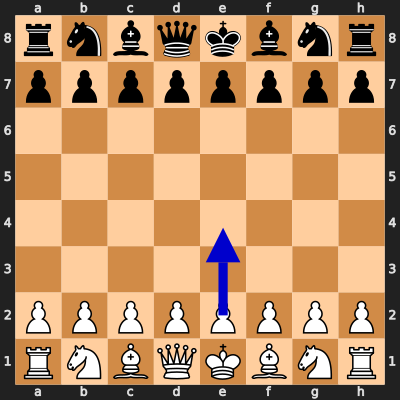

In [15]:
board = chess.Board()

move = get_next_move(board)
draw_board_with_move(move)
board.push(move)

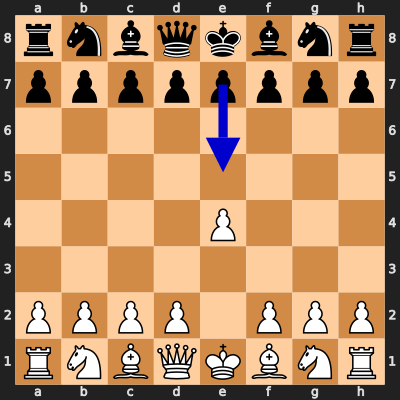

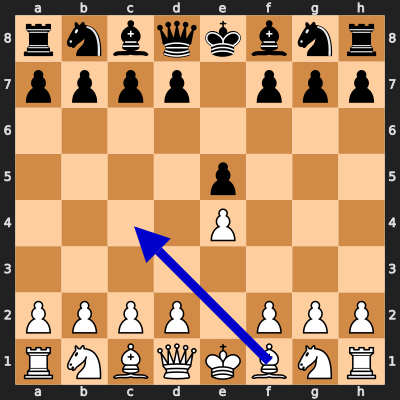

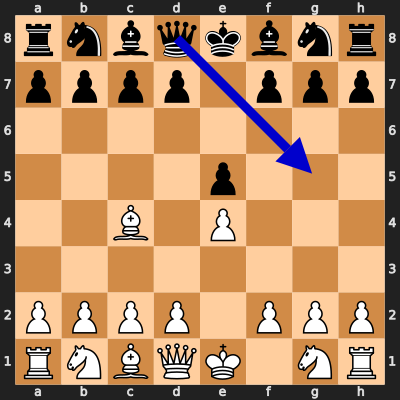

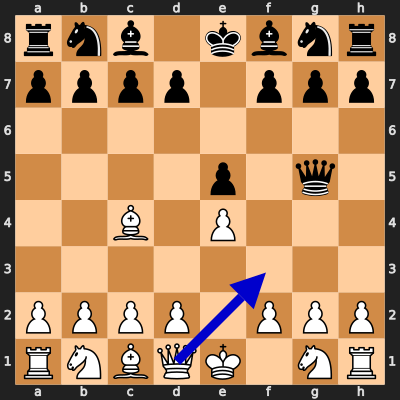

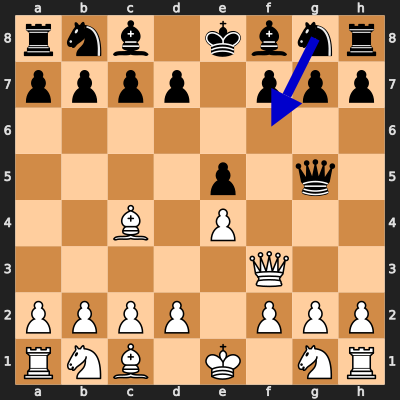

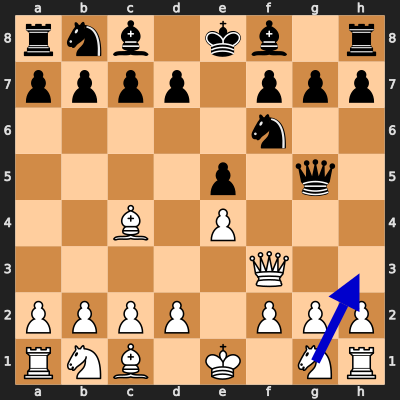

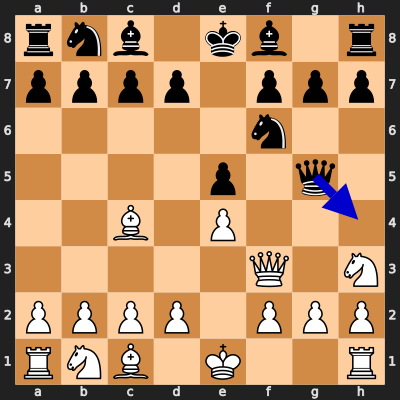

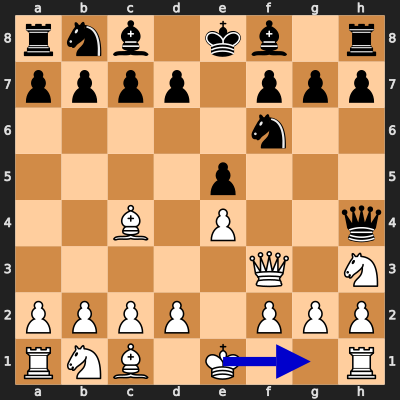

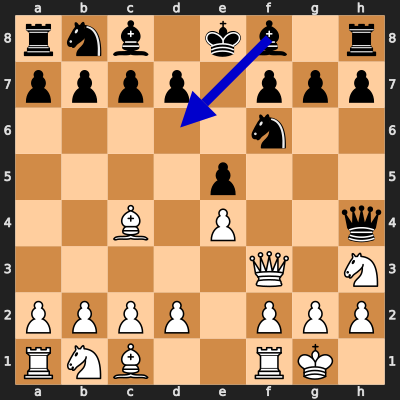

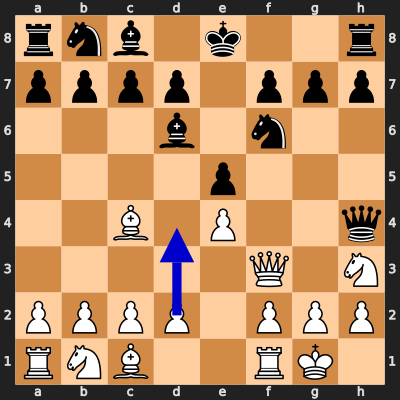

In [16]:
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

# Alpha/Beta pruning

**Goal**: Reduce the number of nodes in the search tree to look at

**Benefit**: Eliminate the need to search large portions of the search tree. Thus, allow for a higher search depth.

**Idea**: You can stop looking at the search tree, if the opponent would never allow this move, because there is a better way to prevent it.

- remember: the search tree is built bottom up
  - white selects the maximizing value of the layer below
  - black selects the minimizing value of the layer below
  - and so on... 
- chess is a **zero-sum game**: _"One player's lower advantage is the other player's disadvantage"_
- maintain two values:
   - `alpha`: minimum score that the maximizing player is assured of
   - `beta`: maximum score that the minimizing player is assured of
- these two values represent the worst case scenario


```mermaid
flowchart TD
    subgraph max
        A
    end

    subgraph min
        B
        C
    end

    subgraph maxx[max]
        D
        G
        J
        L
    end

    subgraph minn[min]
        H
        I
        K
        E
        F
        M
        O
        P
    end

    A[3] --> B[3]
    A -->|worse for white| C[-4]

    B --> D[3]
    D --> E[-1]
    D --> F[3]
    B -->|worse for black| G[5]
    G --> H[5]
    G -.-> I[?]

    C --> J[-4]
    C -.-> L[?]
    J --> K[-6]
    J --> M[-4]
    L -.-> O[?]
    L -.-> P[?]

```

In this example:

- black would choose to play the move that leads to the score of 3 in layer 2, because `min(3,5)=3`
  - thus, the remaining search tree is irrelevant, because black would never allow it
- white would choose to play the move leads to the score of 3 in layer 1, because `max(3, -4)=3`
  - thus, the remaining search three is irrelevant, because white would never go down this route  


In [17]:
def negamax(board, depth, alpha=-10_000, beta=10_000):
    if depth == 0 or board.is_game_over():
        return evaluate(board)
    
    max_score = -INF
    for move in board.legal_moves:
        board.push(move)
        score = -negamax(board, depth - 1, -beta, -alpha)
        board.pop()
        max_score = max(max_score, score)
        alpha = max(alpha, score)
        if alpha >= beta:
            break  # Beta cut-off
    return max_score

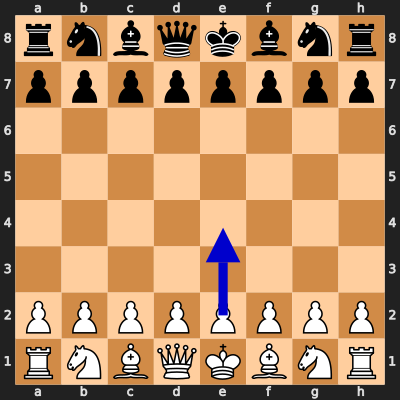

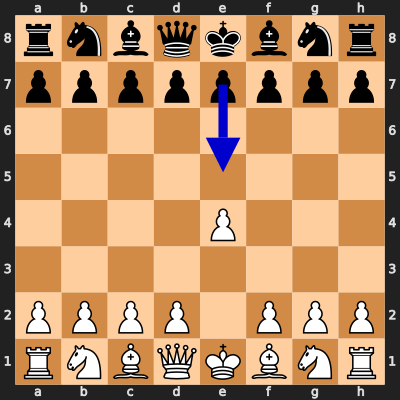

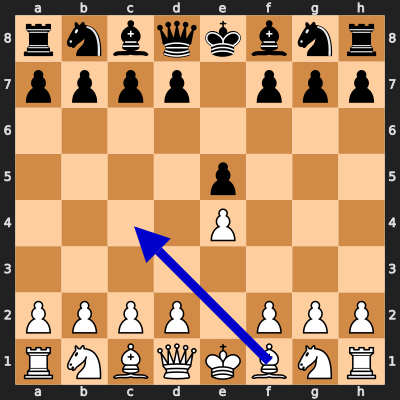

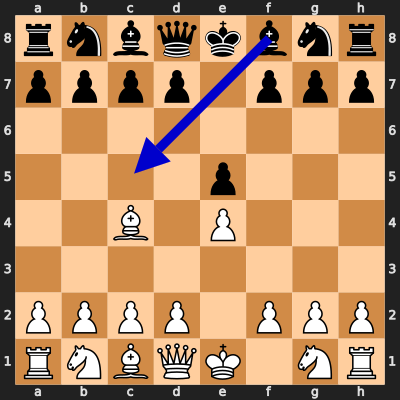

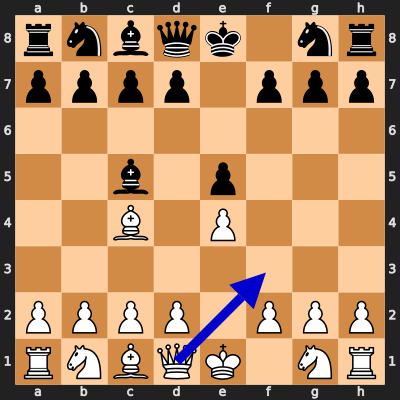

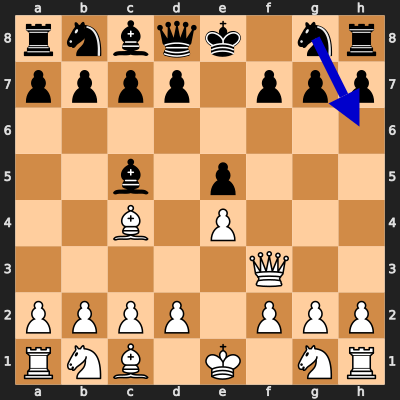

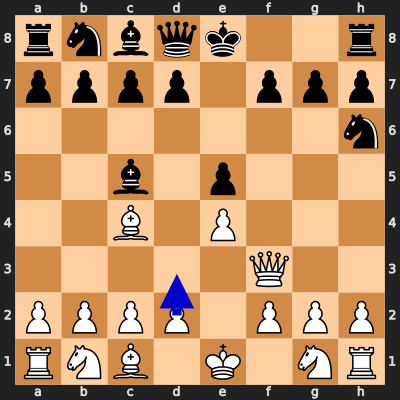

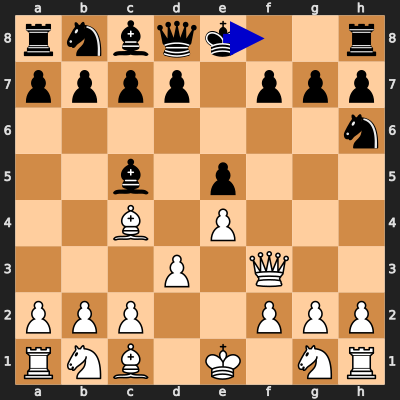

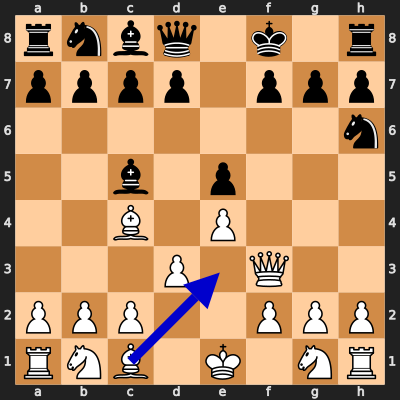

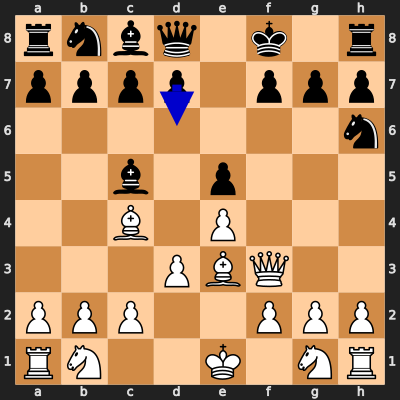

KeyboardInterrupt: 

In [18]:
DEPTH = 4
board = chess.Board()
for _ in range(10):
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

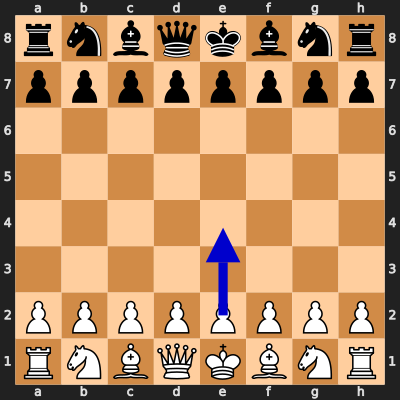

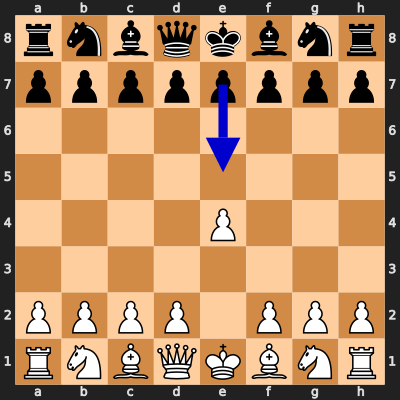

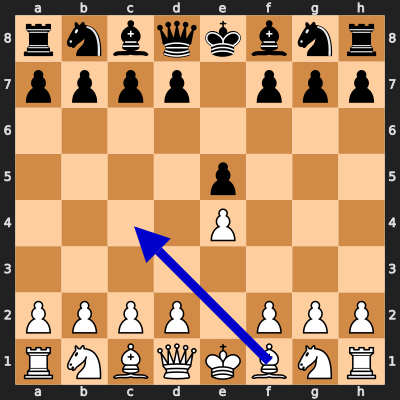

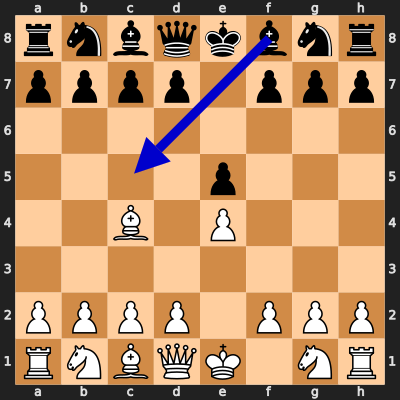

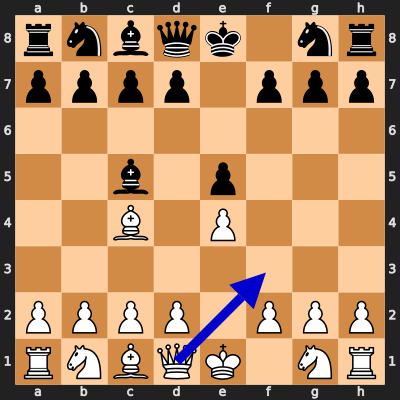

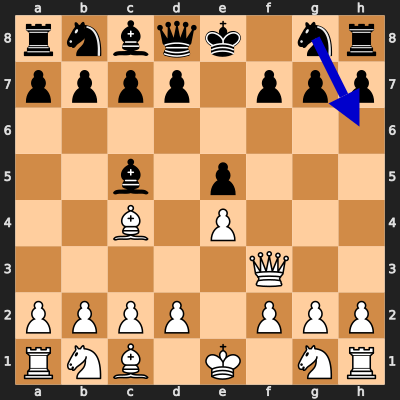

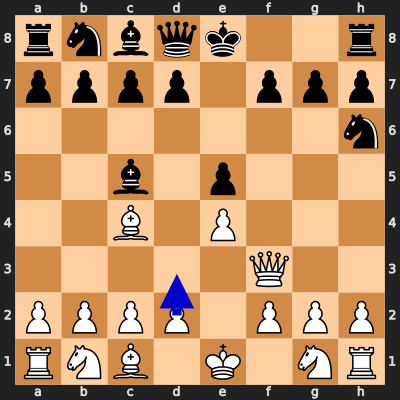

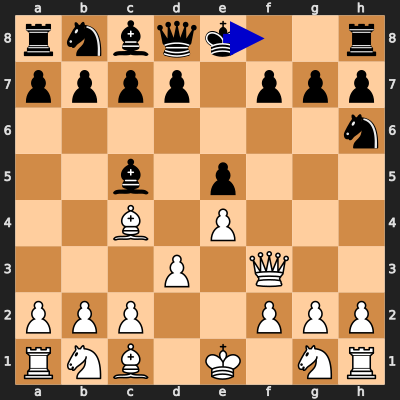

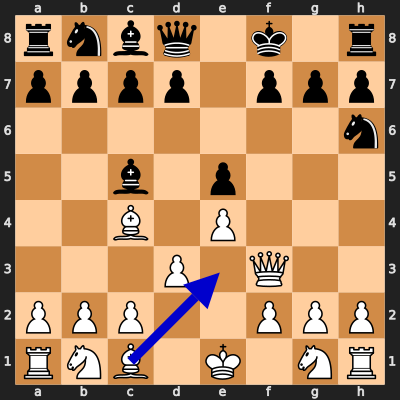

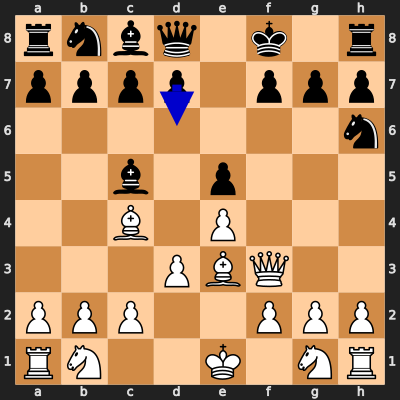

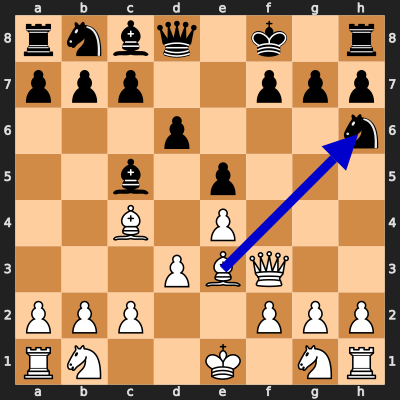

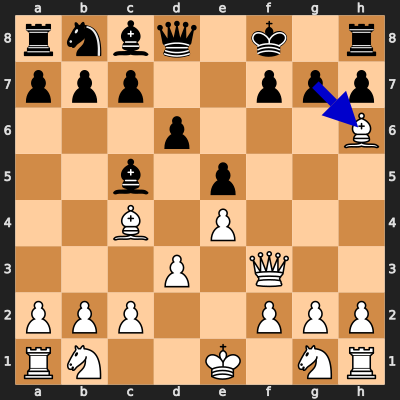

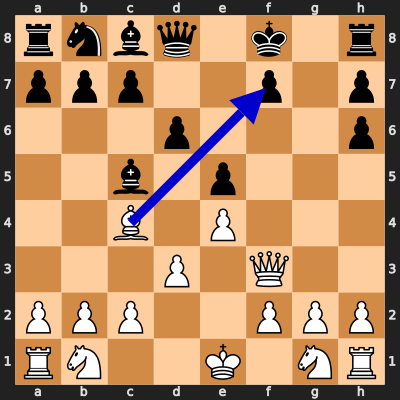

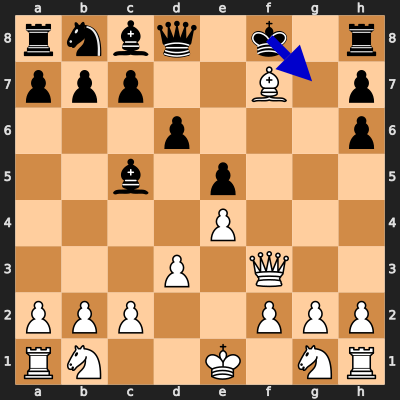

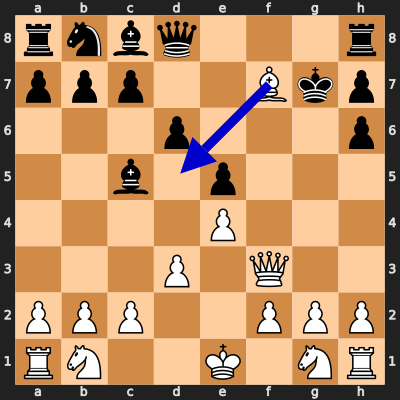

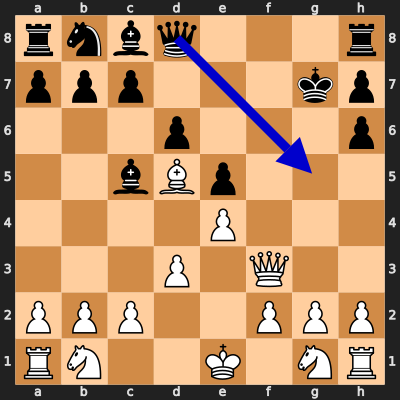

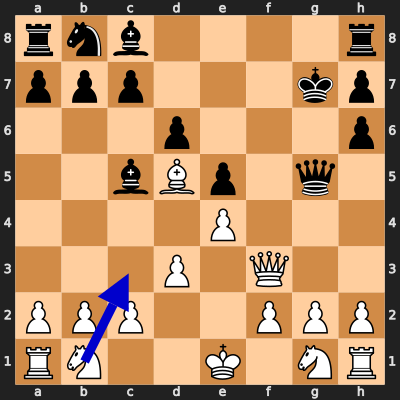

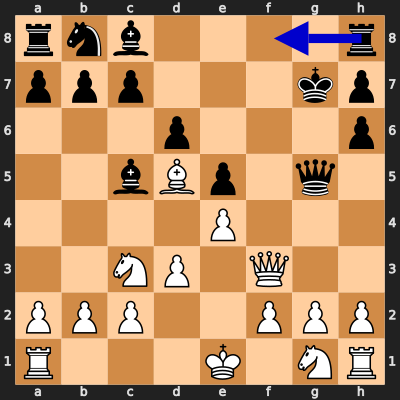

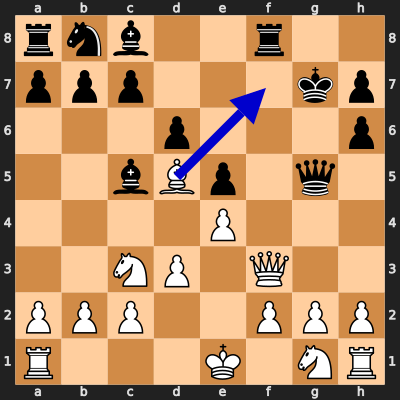

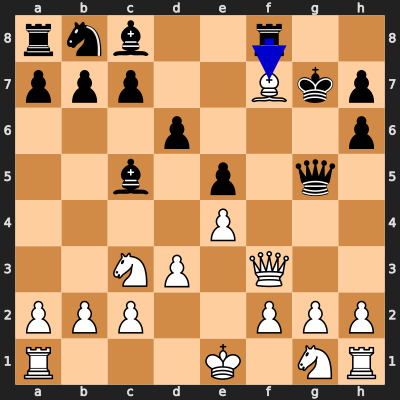

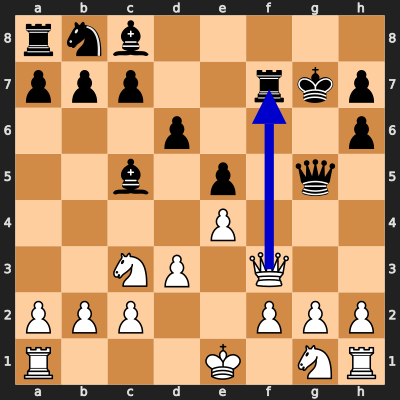

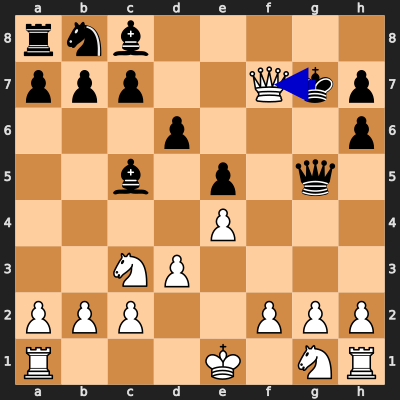

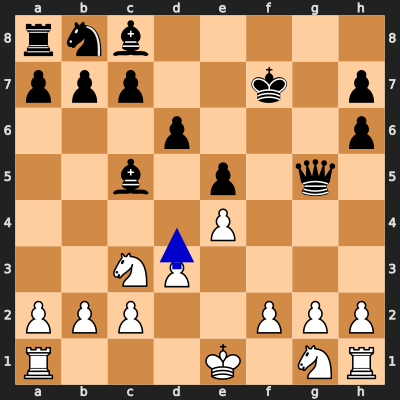

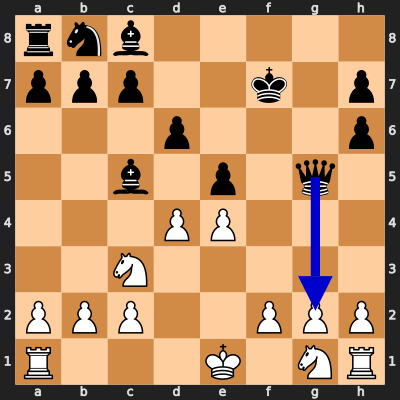

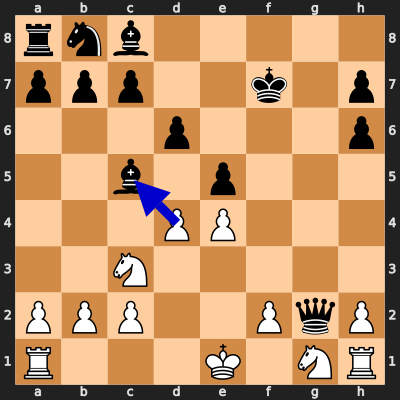

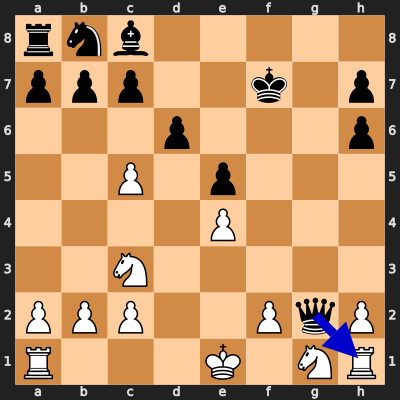

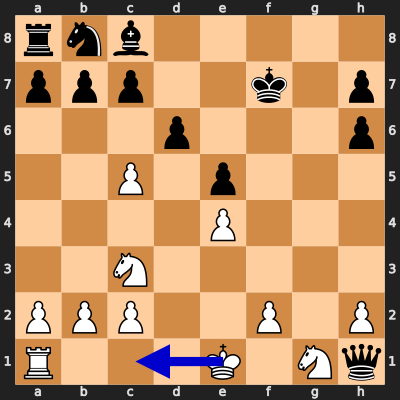

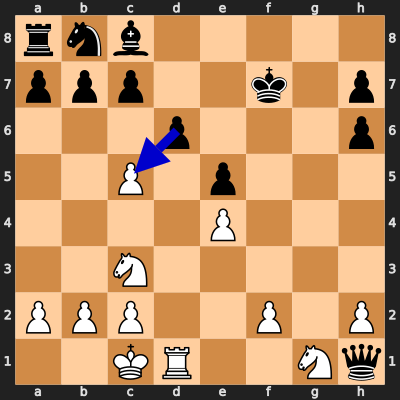

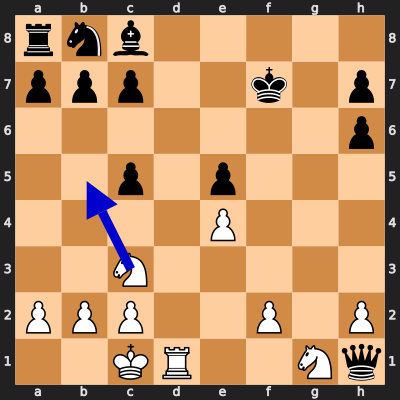

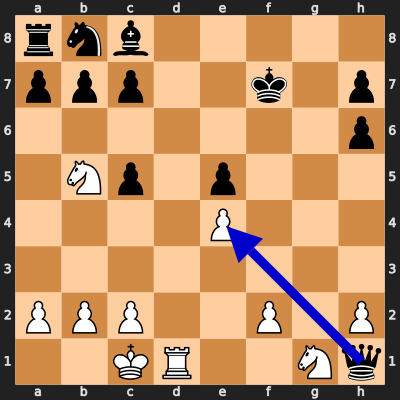

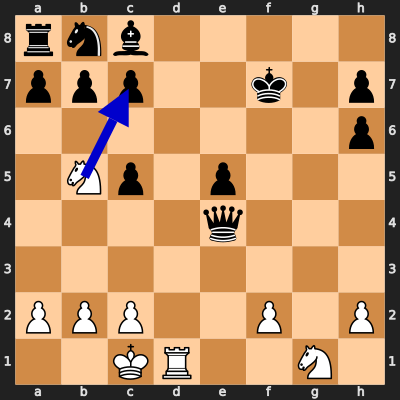

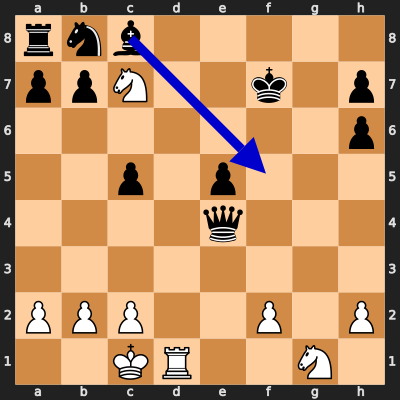

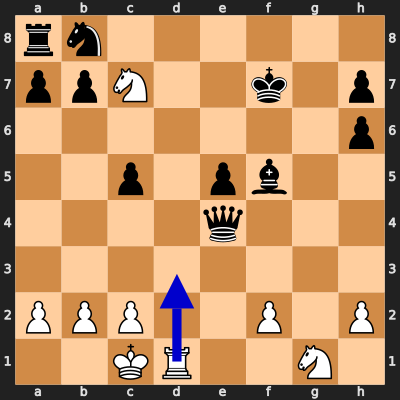

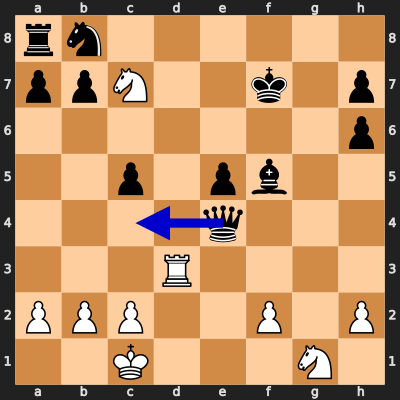

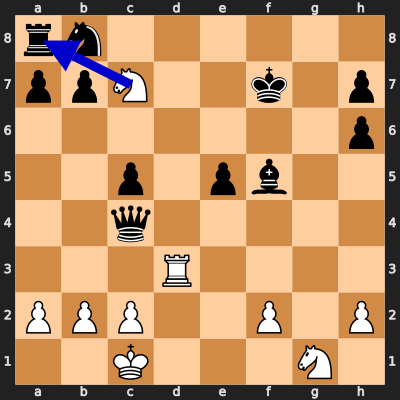

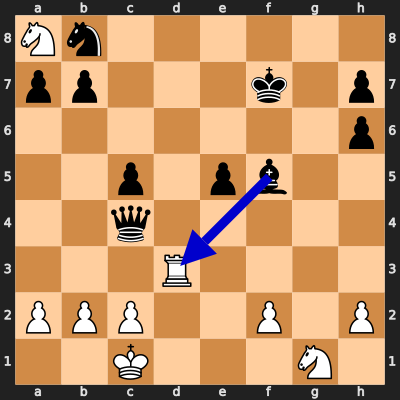

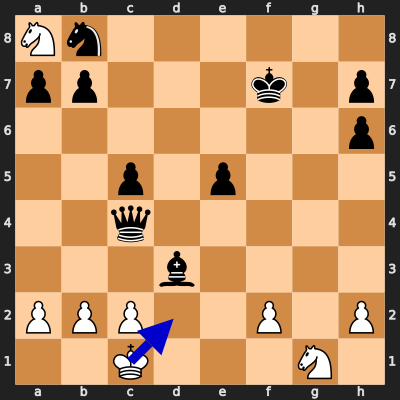

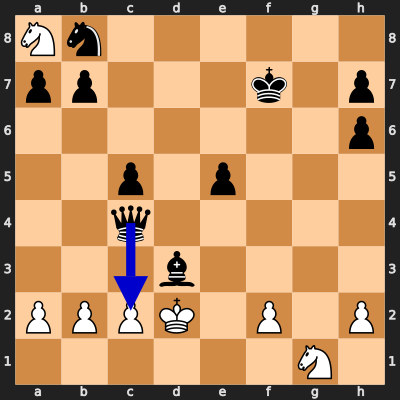

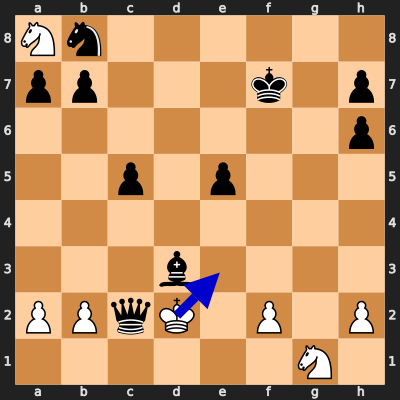

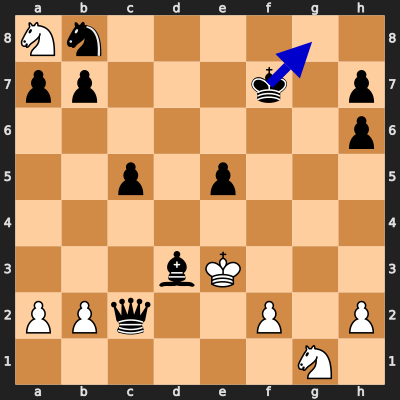

In [19]:
DEPTH = 4
board = chess.Board()
for _ in range(40):
    if board.is_game_over():
        break
    move = get_next_move(board)
    draw_board_with_move(move)
    board.push(move)

In [ ]:
# TODO: https://www.chessprogramming.org/Alpha-Beta
# TODO: Horizon Effect
# TODO: Play regular openings